## Set up basic libraries

In [46]:
import os
from IPython.core.display import display, HTML
print(os.getcwd())
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\hams2


In [47]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
sys.path.insert(0,"../..")
print(os.getcwd())
rootdir=r'C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\\'
os.chdir(rootdir)
print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\hams2
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model


In [48]:
mname='hams2' #root name of model input data

print(os.getcwd())
newdir=rootdir+mname
print(newdir)
os.chdir(newdir)

if not os.path.exists(os.path.isdir('tmp')): 
    os.mkdir('tmp')
    os.mkdir('gempy')
    os.mkdir('dtm')

text=False    #display debug text
graphics=True #display debug images


model_base=-8200 # top could be found using highest point in topo data

minlong=117
maxlong=118
minlat=-23
maxlat=-22

minx=500057    #left hams
maxx=603028    #right
miny=7455348   #bottom
maxy=7567953   #top
    

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found

src_crs = 'epsg:2346'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

# 'epsg:28350'  =  GDA_1994_MGA_Zone_50 
# 'epsg:4326'   =   wgs84 GEODETIC LAT/LONG 

orientation_decimate=0   # decimation of orientaiton data (0 = no decimation)
contact_decimate=30   # decimation of contact data (0 = no decimation)

gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\\hams2


## Load geology map

In [49]:
# Extract point data from WAROX & geology map for gempy
##First we readin the WAROX and map from shapefiles, or wherever...

import geopandas as gpd
import os
from shapely.geometry import Polygon
from shapely.geometry import Point


%matplotlib inline
os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


geology = gpd.read_file('.\\data\\geol_clip.shp')
print(geology.crs)


{'init': 'epsg:28350'}


## Basic explode code

In [50]:
#https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
    
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indf):
#    indf = gpd.GeoDataFrame.from_file(indata)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

## Load topological sorted surfaces

In [51]:
ag=open('.\\tmp\\'+mname+'_all_sorts.txt',"r")
contents =ag.readlines()
ag.close

ulist=[]
for i in range(1,len(contents)):
    cont_list=contents[i].split(",")
    ulist.append([i, cont_list[4].replace("\n","")])
print(ulist)


[[1, 'P_-WYa-st'], [2, 'P_-WYm-sp'], [3, 'P_-WYd-kd'], [4, 'P_-SKq-stq'], [5, 'P_-SKb-bb'], [6, 'P_-TK-s'], [7, 'P_-TKa-xs-k'], [8, 'P_-TKo-stq'], [9, 'P_-TKk-sf'], [10, 'P_-HAo-ci'], [11, 'P_-HAw-fr'], [12, 'P_-HAj-xci-od'], [13, 'P_-HAb-cib'], [14, 'A-HAS-xsl-ci'], [15, 'A-HAd-kd'], [16, 'A-HAm-cib'], [17, 'A-FOj-xs-b'], [18, 'A-FOu-bbo'], [19, 'A-FOp-bs'], [20, 'A-FOo-bbo'], [21, 'A-FOh-xs-f'], [22, 'A-FOr-b'], [23, 'A-s-PMI'], [24, 'A-s-PRK'], [25, 'A-b-PRK']]


## Load all basal contact points

In [52]:
import math
def angle(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    inner_product = x1*x2 + y1*y2
    len1 = math.hypot(x1, y1)
    len2 = math.hypot(x2, y2)
    dot=math.degrees(math.acos(inner_product/(len1*len2)))
    return 90-math.fabs(90-dot)

def pairs(lst):
    for i in range(1, len(lst)):
        yield lst[i-1], lst[i]

        #https://www.geeksforgeeks.org/program-check-three-points-collinear/

# Python program to check 
# if three points are collinear 
# or not using area of triangle. 
  
# function to check if  
# point collinear or not 
def collinear(x1, y1, x2, y2, x3, y3): 
      
    """ Calculation the area of   
        triangle. We have skipped  
        multiplication with 0.5 to 
        avoid floating point computations """
    a = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2) 
    b=x1 * (y2 - y3)
    c=x2 * (y3 - y1)
    d=x3 * (y1 - y2) 
  
    #if (a < 0.000001): 
    #    print ("Yes",a,b,c,d)
    #else: 
    #    print ("No",a,b,c,d)
    return(a< 0.000001)
  
# This code is contributed 
# by Sachin Bisht 

import rasterio

dataset = rasterio.open('.\\dtm\\'+mname+'_dtm_rp.tif')

def height_from_srtm(x,y):
    locations=[(x,y)]
    for val in dataset.sample(locations):
        return(str(val).replace("[","").replace("]",""))


## Create basal contact points with orientation from orientations and basal points

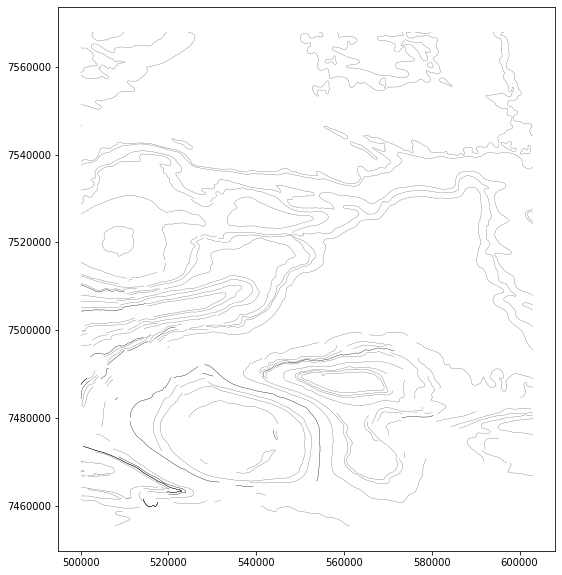

In [58]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import MultiPoint,Point,LineString
from shapely.ops import nearest_points
import math

contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

warox = gpd.read_file('.\\data\\warox_clip.shp') #load orientation data as geopandas dataframe 

contacts.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2)

In [59]:
f=open('.\\gempy\\'+mname+'_projected_dip_contacts2.txt',"w")
f.write('id,x,y,z,DIP,DIP_DIR,polarity,CODE,GROUP_\n')
#print("len=",len(contacts))
i=0
for acontact in contacts.iterrows():   #loop through distinct linestrings
    #display(acontact[1].geometry)
    thegroup=acontact[1]['GROUP_']
    #print("thegroup=",thegroup)
    is_wrx=warox['GROUP_'] == thegroup # subset orientations to just those with this group
    all_wrx = warox[is_wrx]

    for awrx in all_wrx.iterrows(): # loop through valid orientations
        #print(awrx[1].geometry,awrx[1]['GROUP_'])
        orig = Point(awrx[1]['geometry'])
        np = acontact[1].geometry.interpolate(acontact[1].geometry.project(orig))
        if(np.distance(orig)<5000):
            #print(acontact[1]['CODE'],awrx[1]['DIP'],orig,np)                  
            for line in acontact[1].geometry: # loop through line segments
                for pair in pairs(list(line.coords)): # loop through line segments
                    segpair=LineString((pair[0],pair[1]))
                    if segpair.distance(np)< 0.0001: # line segment closest to close point
                        ddx=math.sin(math.radians(awrx[1]['DIP_DIR']))
                        ddy=math.cos(math.radians(awrx[1]['DIP_DIR']))
                        dlsx=pair[0][0]-pair[1][0]
                        dlsy=pair[0][1]-pair[1][1]
                        lsx=dlsx/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        lsy=dlsy/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        angle=math.degrees(math.acos((ddx*lsx)+(ddy*lsy)))
                        #print(i,angle,ls_ddir,lsx,lsy,awrx[1]['DIP_DIR'])
                        if(math.fabs(angle-90)<30.0): # dip_dir normal and contact are close enough to parallel
                            height= height_from_srtm(np.x,np.y)
                            ls_ddir=math.degrees(math.atan2(lsy,-lsx)) #normal to line segment
                            #print(i,ddx,ddy,lsx,lsy,ls_ddir,awrx[1]['DIP_DIR'])
                           
                            if (ddx*lsy)+(-ddy*lsx)<0: #dot product tests right quadrant
                                ls_ddir=(ls_ddir-180)%360
                            ostr=str(i)+","+str(np.x)+","+str(np.y)+","+height+","+str(awrx[1]['DIP'])+","+str(ls_ddir)+",1,"+acontact[1]['CODE']+","+acontact[1]['GROUP_']+"\n" 
                            f.write(ostr)
                            i=i+1


f.close()

## Estimate layer thicknesses

In [55]:
warox = gpd.read_file('./data/warox_clip.shp') #load orientation data as geopandas dataframe 
contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

f=open('./gempy/'+mname+'_estimated_layer_thicknesses.txt',"w")
f.write('id,x,y,CODE,thickness\n')

all_sorts=pd.read_csv('./tmp/'+mname+'_all_sorts.txt')
#display(all_sorts)
i=0
print("id,x,y,code,group")
for apair in all_sorts.iterrows():
    for bpair in all_sorts.iterrows():
        if(int(apair[1]['index'])==(int(bpair[1]['index'])+1) and apair[1]['group']==bpair[1]['group'] ):
            #print(apair[1]['code'],apair[1]['group'])
            #print(warox.shape)
            is_wrx=warox['GROUP_'] == apair[1]['group'] # subset orientations to just those with this group
            all_wrx = warox[is_wrx]      
            #print(all_wrx.shape)
            is_contacta=contacts['CODE'] == apair[1]['code'] # subset contacts to just those with a code
            acontacts = contacts[is_contacta]
            
            is_contactb=contacts['CODE'] == bpair[1]['code'] # subset contacts to just those with b code
            bcontacts = contacts[is_contactb]

            for awrx in all_wrx.iterrows(): # loop through valid orientations
                
                dx1=math.sin(math.radians(awrx[1]['DIP_DIR']))*1e5
                dy1=math.cos(math.radians(awrx[1]['DIP_DIR']))*1e5
                dx2=-dx1
                dy2=-dy1
                p1=Point((dx1+awrx[1]['geometry'].x,dy1+awrx[1]['geometry'].y))
                p2=Point((dx2+awrx[1]['geometry'].x,dy2+awrx[1]['geometry'].y))
                ddline=LineString((p1,p2))
                orig = Point(awrx[1]['geometry'])

                for acontact in acontacts.iterrows():   #loop through distinct linestrings for upper contact
                    #print(acontact[1]['CODE'],apair[1]['code'])
                    #break
                    if(ddline.intersects(acontact[1].geometry)): 
                        isects=ddline.intersection(acontact[1].geometry)
                        #print(type(isects),isects)
                        if(isects.geom_type=="MultiPoint"):
                            for pt in isects: 
                                if(pt.distance(orig)<1000):
                                    print(i,",", pt.x, ",",pt.y,",",apair[1]['code'],",",apair[1]['group'])
                                    i=i+1
                        else:
                            if(isects.distance(orig)<1000):
                                print(i,",", isects.x,",", isects.y,",",apair[1]['code'],",",apair[1]['group'])
                                i=i+1
                
                for bcontact in bcontacts.iterrows():   #loop through distinct linestrings for lower contact
                    #break
                    if(ddline.intersects(bcontact[1].geometry)): 
                        isects=ddline.intersection(bcontact[1].geometry)
                        if(isects.geom_type=="MultiPoint"):
                            for pt in isects: 
                                if(pt.distance(orig)<15000):
                                    print(i,",", pt.x, ",",pt.y,",",bpair[1]['code'],",",bpair[1]['group'])
                                    i=i+1
                        else:
                            if(isects.distance(orig)<15000):
                                print(i,",", isects.x,",", isects.y,",",bpair[1]['code'],",",bpair[1]['group'])
                                i=i+1
            

id,x,y,code,group
0 , 503517.6591896642 , 7469649.220456804 , P_-TK-s , Turee Creek Group
1 , 503306.7931686398 , 7469692.746706662 , P_-TK-s , Turee Creek Group
2 , 506347.23531252716 , 7507214.949096731 , P_-TK-s , Turee Creek Group
3 , 506734.2878589084 , 7501679.839807122 , P_-TK-s , Turee Creek Group
4 , 519176.2989944205 , 7510577.864206427 , P_-HAo-ci , Hamersley Group
5 , 522003.25098897575 , 7511263.4492883 , P_-HAo-ci , Hamersley Group
6 , 513175.2595870358 , 7512004.91182013 , P_-HAo-ci , Hamersley Group
7 , 512360.4959606062 , 7509497.327220379 , P_-HAo-ci , Hamersley Group
8 , 511053.0975996128 , 7505473.568808219 , P_-HAo-ci , Hamersley Group
9 , 508040.55726586835 , 7496201.923017978 , P_-HAo-ci , Hamersley Group
10 , 508040.55726586835 , 7496201.923017978 , P_-HAo-ci , Hamersley Group
11 , 519116.346869558 , 7541354.573763469 , P_-HAw-fr , Hamersley Group
12 , 519085.15765032294 , 7541651.319362314 , P_-HAw-fr , Hamersley Group
13 , 539518.9712941664 , 7521625.299932528

117 , 530705.7461415365 , 7500676.542322809 , P_-HAj-xci-od , Hamersley Group
118 , 539816.4860232514 , 7522140.100427552 , P_-HAj-xci-od , Hamersley Group
119 , 536559.7934930685 , 7500775.518485127 , P_-HAj-xci-od , Hamersley Group
120 , 540688.2785449532 , 7522014.7328386735 , P_-HAj-xci-od , Hamersley Group
121 , 542955.2854492222 , 7504969.149040387 , P_-HAj-xci-od , Hamersley Group
122 , 552640.602675755 , 7515573.585832984 , P_-HAj-xci-od , Hamersley Group
123 , 550149.5039241397 , 7520613.260632593 , P_-HAj-xci-od , Hamersley Group
124 , 538972.8642384984 , 7522163.475230113 , P_-HAj-xci-od , Hamersley Group
125 , 549683.9767032122 , 7514092.073051221 , P_-HAj-xci-od , Hamersley Group
126 , 547492.7269928869 , 7512900.133550231 , P_-HAj-xci-od , Hamersley Group
127 , 548255.4169552554 , 7521617.719710895 , P_-HAj-xci-od , Hamersley Group
128 , 547952.3973881966 , 7521755.343040935 , P_-HAj-xci-od , Hamersley Group
129 , 549067.7258590435 , 7513819.368608957 , P_-HAj-xci-od , Ha

232 , 543159.4130958238 , 7528052.669995142 , A-HAd-kd , Hamersley Group
233 , 577331.4957890378 , 7488812.705562837 , A-HAd-kd , Hamersley Group
234 , 573951.9113684382 , 7481565.163384415 , A-HAd-kd , Hamersley Group
235 , 576138.6456728588 , 7485643.993343315 , A-HAd-kd , Hamersley Group
236 , 577486.1776524916 , 7486900.587243376 , A-HAd-kd , Hamersley Group
237 , 578370.2672357529 , 7487725.014117264 , A-HAd-kd , Hamersley Group
238 , 523039.2686288807 , 7542371.012823122 , A-HAd-kd , Hamersley Group
239 , 523325.76856858825 , 7543080.1250573965 , A-HAd-kd , Hamersley Group
240 , 522028.91163266764 , 7538211.934783845 , A-FOj-xs-b , Fortescue Group
241 , 521482.3901590749 , 7538927.804838778 , A-FOj-xs-b , Fortescue Group
242 , 522944.0151883729 , 7533548.390947246 , A-FOj-xs-b , Fortescue Group
243 , 537894.9451483875 , 7519591.625151772 , A-FOj-xs-b , Fortescue Group
244 , 540599.2434056362 , 7532314.348157834 , A-FOj-xs-b , Fortescue Group
245 , 536423.9609868841 , 7518820.7492

343 , 562027.3001088692 , 7467529.336750407 , A-FOu-bbo , Fortescue Group
344 , 572690.6372223514 , 7470386.569318586 , A-FOu-bbo , Fortescue Group
345 , 578521.3699357363 , 7470459.6089331405 , A-FOu-bbo , Fortescue Group
346 , 573199.7024095111 , 7469711.697336997 , A-FOu-bbo , Fortescue Group
347 , 577853.7182028444 , 7466930.48895766 , A-FOu-bbo , Fortescue Group
348 , 578519.3622103572 , 7470519.259613348 , A-FOu-bbo , Fortescue Group
349 , 583264.5844054873 , 7479700.795156557 , A-FOu-bbo , Fortescue Group
350 , 586814.8487778918 , 7480329.051172618 , A-FOu-bbo , Fortescue Group
351 , 586611.2780616957 , 7480275.916358972 , A-FOu-bbo , Fortescue Group
352 , 581601.8805037554 , 7479316.164456411 , A-FOu-bbo , Fortescue Group
353 , 530828.6786907102 , 7490633.981496935 , A-FOp-bs , Fortescue Group
354 , 533290.593718842 , 7488527.708471198 , A-FOp-bs , Fortescue Group
355 , 518456.91658891033 , 7471371.322733781 , A-FOp-bs , Fortescue Group
356 , 518437.694681478 , 7471384.23088991

In [229]:
                    
                    np = acontact[1].geometry.interpolate(acontact[1].geometry.project(orig))
                    if(np.distance(orig)<1000):
                        #print(acontact[1]['CODE'],awrx[1]['DIP'],orig,np)                  
                        for line in acontact[1].geometry: # loop through line segments
                            for pair in pairs(list(line.coords)): # loop through line segments
                                segpair=LineString((pair[0],pair[1]))
                                if segpair.distance(np)< 0.0001: # line segment closest to close point
                                    ddx=math.sin(math.radians(awrx[1]['DIP_DIR']))
                                    ddy=math.cos(math.radians(awrx[1]['DIP_DIR']))
                                    dlsx=pair[0][0]-pair[1][0]
                                    dlsy=pair[0][1]-pair[1][1]
                                    lsx=dlsx/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                                    lsy=dlsy/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                                    angle=math.degrees(math.acos((ddx*lsx)+(ddy*lsy)))
                                    #print(i,angle,ls_ddir,lsx,lsy,awrx[1]['DIP_DIR'])
                                    if(math.fabs(angle-90)<30.0): # # dip_dir normal and contact are close enough to parallel
                                        print(orig,np)
                                        bigddx=ddx*1.e5
                                        bigddy=ddy*1.e5
        

1 P_-WYm-sp Wyloo Group 0 P_-WYa-st Wyloo Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
2,70,181,182,942,905,4177,P_-WYm-sp,Mount McGrath Formation,Formal,Formation,...,1799,None,Inferred,Inferred,2014-12-04,1.083165,904,1.083165,0.006600,POINT (504669.3230735423 7461016.86484253)
3,45,182,173,924,887,1413,P_-WYd-kd,Duck Creek Dolomite,Formal,Formation,...,1799,None,Inferred,Inferred,2014-12-04,5.915156,886,5.915156,0.100818,POINT (503404.3319343358 7460230.336055614)
120,25,16,171,868,831,1412,P_-WYa-st,Ashburton Formation,Informal,Member,...,1799,None,Inferred,Inferred,2014-12-04,1.438710,830,1.438710,0.022895,POINT (507893.2889237558 7457420.420091962)


POINT (504669.3230735423 7461016.86484253) POINT (504727.5524423859 7461703.552111425)
POINT (503404.3319343358 7460230.336055614) POINT (503666.2539629288 7460984.346020031)
2 P_-WYd-kd Wyloo Group 1 P_-WYm-sp Wyloo Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
2,70,181,182,942,905,4177,P_-WYm-sp,Mount McGrath Formation,Formal,Formation,...,1799,None,Inferred,Inferred,2014-12-04,1.083165,904,1.083165,0.006600,POINT (504669.3230735423 7461016.86484253)
3,45,182,173,924,887,1413,P_-WYd-kd,Duck Creek Dolomite,Formal,Formation,...,1799,None,Inferred,Inferred,2014-12-04,5.915156,886,5.915156,0.100818,POINT (503404.3319343358 7460230.336055614)
120,25,16,171,868,831,1412,P_-WYa-st,Ashburton Formation,Informal,Member,...,1799,None,Inferred,Inferred,2014-12-04,1.438710,830,1.438710,0.022895,POINT (507893.2889237558 7457420.420091962)


4 P_-SKb-bb Shingle Creek Group 3 P_-SKq-stq Shingle Creek Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
4,10,199,169,863,826,4227,P_-SKq-stq,Beasley River Quartzite,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,0.058327,825,0.058327,0.000203,POINT (517319.4798376544 7458551.539931033)
9,68,3,165,802,766,4227,P_-SKq-stq,Beasley River Quartzite,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,0.177941,765,0.177941,0.000318,POINT (503809.7052735864 7463489.819689126)
10,16,213,176,933,896,4227,P_-SKq-stq,Beasley River Quartzite,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,0.219685,895,0.219685,0.001383,POINT (502536.4299599883 7468201.274627255)
11,12,186,176,933,896,4227,P_-SKq-stq,Beasley River Quartzite,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,0.219685,895,0.219685,0.001383,POINT (502536.4190857027 7469579.769568286)
13,10,216,176,933,896,4227,P_-SKq-stq,Beasley River Quartzite,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,0.219685,895,0.219685,0.001383,POINT (507187.8769412696 7468501.372442812)


6 P_-TKa-xs-k Turee Creek Group 5 P_-TK-s Turee Creek Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
5,45,227,167,826,789,4068,P_-TK-s,Turee Creek Group,Formal,Group,...,2208,None,Inferred,Inferred,2014-12-04,0.142272,788,0.142272,0.000533,POINT (516865.3849028363 7458957.04590488)
7,58,203,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (507945.2849673012 7467495.909622293)
8,60,0,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (503517.6591896642 7466603.797579262)
12,82,360,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (503306.7931686398 7465431.798659263)
20,28,356,123,641,605,4068,P_-TK-s,Turee Creek Group,Formal,Group,...,2208,None,Inferred,Inferred,2014-12-04,1.028081,604,1.028081,0.012047,POINT (506680.4801311303 7502449.32616411)


7 P_-TKo-stq Turee Creek Group 6 P_-TKa-xs-k Turee Creek Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
5,45,227,167,826,789,4068,P_-TK-s,Turee Creek Group,Formal,Group,...,2208,None,Inferred,Inferred,2014-12-04,0.142272,788,0.142272,0.000533,POINT (516865.3849028363 7458957.04590488)
7,58,203,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (507945.2849673012 7467495.909622293)
8,60,0,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (503517.6591896642 7466603.797579262)
12,82,360,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (503306.7931686398 7465431.798659263)
20,28,356,123,641,605,4068,P_-TK-s,Turee Creek Group,Formal,Group,...,2208,None,Inferred,Inferred,2014-12-04,1.028081,604,1.028081,0.012047,POINT (506680.4801311303 7502449.32616411)


POINT (503517.6591896642 7466603.797579262) POINT (503520.2090067365 7466690.504882566)
8 P_-TKk-sf Turee Creek Group 7 P_-TKo-stq Turee Creek Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
5,45,227,167,826,789,4068,P_-TK-s,Turee Creek Group,Formal,Group,...,2208,None,Inferred,Inferred,2014-12-04,0.142272,788,0.142272,0.000533,POINT (516865.3849028363 7458957.04590488)
7,58,203,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (507945.2849673012 7467495.909622293)
8,60,0,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (503517.6591896642 7466603.797579262)
12,82,360,180,939,902,4100,P_-TKk-sf,Kungarra Formation,Formal,Formation,...,2208,None,Inferred,Inferred,2014-12-04,1.477049,901,1.477049,0.017285,POINT (503306.7931686398 7465431.798659263)
20,28,356,123,641,605,4068,P_-TK-s,Turee Creek Group,Formal,Group,...,2208,None,Inferred,Inferred,2014-12-04,1.028081,604,1.028081,0.012047,POINT (506680.4801311303 7502449.32616411)


10 P_-HAw-fr Hamersley Group 9 P_-HAo-ci Hamersley Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


POINT (515438.1815205008 7463725.081268248) POINT (515453.5816392663 7463819.611901089)
POINT (555431.8322593918 7486296.281400428) POINT (555189.9148915044 7485844.416407746)
POINT (554774.5212544654 7485480.277666663) POINT (555018.5810206363 7485936.144334764)
POINT (559041.5638555064 7491264.804765273) POINT (559092.2451115514 7491090.521718825)
11 P_-HAj-xci-od Hamersley Group 10 P_-HAw-fr Hamersley Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


POINT (515438.1815205008 7463725.081268248) POINT (515474.783577639 7463132.915013756)
POINT (521831.6480109566 7509302.018274232) POINT (521808.0757329997 7509014.237554852)
POINT (535718.0192939468 7512484.71788707) POINT (535687.9466666022 7512311.73501206)
POINT (538686.8338592579 7511718.192543137) POINT (538581.930952033 7511527.538778118)
POINT (540927.0566014647 7507144.158193491) POINT (540297.6505259095 7507602.179720042)
POINT (554774.5212544654 7485480.277666663) POINT (554670.7711548519 7485101.395400972)
12 P_-HAb-cib Hamersley Group 11 P_-HAj-xci-od Hamersley Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


POINT (522302.8166457202 7500351.485759936) POINT (522173.6001412771 7501178.18488456)
POINT (521831.6480109566 7509302.018274232) POINT (521750.9708386878 7509683.744437198)
POINT (519044.0420902803 7542042.5077853) POINT (518958.9730255263 7541681.01394285)
POINT (554774.5212544654 7485480.277666663) POINT (554413.856769033 7484660.698395412)
POINT (547193.675405852 7515968.649679823) POINT (546975.3428564522 7516349.076068731)
POINT (547505.9686688377 7536844.754766093) POINT (547369.5618576325 7536628.817309752)
POINT (568699.0559527974 7537244.204769069) POINT (568659.611393888 7537023.701141583)
POINT (568699.0559527974 7537244.204769069) POINT (568659.611393888 7537023.701141583)
POINT (574022.9605266358 7481717.528795866) POINT (573837.271808068 7481424.532577526)
POINT (574022.9605266358 7481717.528795866) POINT (573990.856025648 7481557.357379962)
POINT (523580.6783817719 7543711.048984814) POINT (523429.7435618002 7543056.161480774)
13 A-HAS-xsl-ci Hamersley Group 12 P_-HAb-

,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


POINT (522302.8166457202 7500351.485759936) POINT (522291.1527659922 7500071.293026398)
POINT (521831.6480109566 7509302.018274232) POINT (521671.4390245664 7509957.018825785)
POINT (521831.6480109566 7509302.018274232) POINT (521671.4390245664 7509957.018825785)
POINT (519044.0420902803 7542042.5077853) POINT (518867.7708056364 7541425.600336782)
POINT (544783.4545960588 7514188.158635112) POINT (544811.839903061 7514178.139503223)
POINT (547193.675405852 7515968.649679823) POINT (547175.1831368366 7515990.816736691)
POINT (571120.6228392244 7560759.886930016) POINT (571761.1885145381 7560498.885521324)
POINT (574022.9605266358 7481717.528795866) POINT (573415.5305613433 7481007.030296098)
14 A-HAd-kd Hamersley Group 13 A-HAS-xsl-ci Hamersley Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


POINT (522302.8166457202 7500351.485759936) POINT (522262.5892494384 7500072.482070159)
POINT (542044.7288873353 7531755.560329944) POINT (542052.6515354244 7532077.260947511)
POINT (531127.7730774952 7532018.492116442) POINT (530560.3692961445 7532478.500666112)
POINT (526028.0984672657 7531015.837929202) POINT (526127.4409470722 7531251.988764911)
POINT (538013.208028096 7522087.242238302) POINT (538006.3611580072 7521636.377630815)
POINT (548338.5407104825 7531498.098746012) POINT (548537.9105693212 7532328.937642916)
POINT (546295.4105379576 7532604.629010826) POINT (546346.691302537 7532822.764256514)
POINT (570473.7697480624 7530572.664886281) POINT (570001.2687307628 7531084.932226645)
POINT (574022.9605266358 7481717.528795866) POINT (574108.3273543202 7480927.019330755)
15 A-HAm-cib Hamersley Group 14 A-HAd-kd Hamersley Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
6,44,359,71,312,278,4111,P_-HAj-xci-od,Weeli Wolli Formation,Formal,Formation,...,2450,None,Inferred,Inferred,2014-12-04,0.110114,277,0.110114,0.000260,POINT (515438.1815205008 7463725.081268248)
19,29,343,134,666,630,4124,A-HAS-xsl-ci,Mount McRae Shale and Mount Sylvia Formation,Informal,Subgroup,...,2501,None,Inferred,Inferred,2014-12-04,0.250994,629,0.250994,0.000575,POINT (522302.8166457202 7500351.485759936)
21,52,185,3,17,12,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,5.308226,11,5.308226,0.057164,POINT (521831.6480109566 7509302.018274232)
22,52,198,124,642,606,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,3.207429,605,3.207429,0.010146,POINT (512448.4070340338 7509767.889683803)
28,10,354,184,959,919,4113,P_-HAb-cib,Brockman Iron Formation,Formal,Formation,...,2451,None,Inferred,Inferred,2014-12-04,11.316451,918,11.316451,0.492442,POINT (519044.0420902803 7542042.5077853)
30,5,14,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (542044.7288873353 7531755.560329944)
31,14,55,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (538856.7223174372 7532188.570002678)
32,8,223,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (533510.5209025822 7532566.044778457)
34,20,313,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (531127.7730774952 7532018.492116442)
36,18,27,119,635,599,2258,A-HAm-cib,Marra Mamba Iron Formation,Formal,Formation,...,2597,5,Inferred,Isotopic,2014-12-04,7.640042,598,7.640042,0.045693,POINT (526028.0984672657 7531015.837929202)


POINT (522302.8166457202 7500351.485759936) POINT (522299.6494859044 7499767.252888206)
POINT (542044.7288873353 7531755.560329944) POINT (541852.7791755521 7531326.029677808)
POINT (542044.7288873353 7531755.560329944) POINT (541852.7791755521 7531326.029677808)
POINT (526028.0984672657 7531015.837929202) POINT (525587.5730342289 7530215.195000193)
POINT (538013.208028096 7522087.242238302) POINT (538015.904131482 7522189.994650426)
POINT (570473.7697480624 7530572.664886281) POINT (570873.129057231 7530053.226352632)
17 A-FOu-bbo Fortescue Group 16 A-FOj-xs-b Fortescue Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
0,55,8,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (530083.1853321539 7485329.520625224)
1,40,10,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (532466.0586118693 7483851.537509387)
14,70,207,56,248,214,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,0.846711,213,0.846711,0.005963,POINT (517107.0336764473 7468722.02834858)
15,51,207,185,960,920,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,11.920632,919,11.920632,0.257717,POINT (517762.2141241012 7470058.525651742)
16,30,273,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (522004.8079015461 7478030.914453515)
17,15,318,1,2,2,4144,A-FOp-bs,Pyradie Formation,Formal,Formation,...,2718,None,Inferred,Inferred,2014-12-04,2.091002,1,2.091002,0.017331,POINT (513032.89981243 7482922.32860626)
18,15,317,175,926,889,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,1.161302,888,1.161302,0.005926,POINT (507595.3381617991 7487654.271563679)
23,8,77,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (515006.8389949187 7524809.562893802)
24,20,16,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (510218.9128006434 7523642.403164269)
25,16,20,12,75,58,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,14.712921,57,14.712921,0.087554,POINT (518496.7412470335 7528507.376407649)


POINT (513032.89981243 7482922.32860626) POINT (512711.7966885627 7483216.124448001)
POINT (510218.9128006434 7523642.403164269) POINT (510156.1492969504 7523457.5319568)
POINT (529500.7380257527 7466242.373478049) POINT (529426.3063104521 7465607.728441434)
POINT (550491.0057451132 7482012.754560061) POINT (550726.5090877599 7482625.749835017)
POINT (550491.0057451132 7482012.754560061) POINT (550726.5090877599 7482625.749835017)
POINT (544268.3481721996 7484998.20256854) POINT (544346.2506034099 7485168.030212103)
18 A-FOp-bs Fortescue Group 17 A-FOu-bbo Fortescue Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
0,55,8,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (530083.1853321539 7485329.520625224)
1,40,10,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (532466.0586118693 7483851.537509387)
14,70,207,56,248,214,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,0.846711,213,0.846711,0.005963,POINT (517107.0336764473 7468722.02834858)
15,51,207,185,960,920,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,11.920632,919,11.920632,0.257717,POINT (517762.2141241012 7470058.525651742)
16,30,273,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (522004.8079015461 7478030.914453515)
17,15,318,1,2,2,4144,A-FOp-bs,Pyradie Formation,Formal,Formation,...,2718,None,Inferred,Inferred,2014-12-04,2.091002,1,2.091002,0.017331,POINT (513032.89981243 7482922.32860626)
18,15,317,175,926,889,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,1.161302,888,1.161302,0.005926,POINT (507595.3381617991 7487654.271563679)
23,8,77,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (515006.8389949187 7524809.562893802)
24,20,16,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (510218.9128006434 7523642.403164269)
25,16,20,12,75,58,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,14.712921,57,14.712921,0.087554,POINT (518496.7412470335 7528507.376407649)


POINT (540784.7311849125 7464544.231918607) POINT (540746.7957420138 7465231.734801204)
POINT (529500.7380257527 7466242.373478049) POINT (529543.9025393792 7466393.240708333)
19 A-FOo-bbo Fortescue Group 18 A-FOp-bs Fortescue Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
0,55,8,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (530083.1853321539 7485329.520625224)
1,40,10,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (532466.0586118693 7483851.537509387)
14,70,207,56,248,214,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,0.846711,213,0.846711,0.005963,POINT (517107.0336764473 7468722.02834858)
15,51,207,185,960,920,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,11.920632,919,11.920632,0.257717,POINT (517762.2141241012 7470058.525651742)
16,30,273,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (522004.8079015461 7478030.914453515)
17,15,318,1,2,2,4144,A-FOp-bs,Pyradie Formation,Formal,Formation,...,2718,None,Inferred,Inferred,2014-12-04,2.091002,1,2.091002,0.017331,POINT (513032.89981243 7482922.32860626)
18,15,317,175,926,889,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,1.161302,888,1.161302,0.005926,POINT (507595.3381617991 7487654.271563679)
23,8,77,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (515006.8389949187 7524809.562893802)
24,20,16,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (510218.9128006434 7523642.403164269)
25,16,20,12,75,58,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,14.712921,57,14.712921,0.087554,POINT (518496.7412470335 7528507.376407649)


POINT (542701.7453036447 7483245.181959859) POINT (542742.6988459862 7483381.630640737)
POINT (529500.7380257527 7466242.373478049) POINT (529636.7983848706 7466749.55146764)
POINT (590450.5487317103 7475839.335637633) POINT (590186.1186676702 7475817.327053281)
20 A-FOh-xs-f Fortescue Group 19 A-FOo-bbo Fortescue Group


,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
0,55,8,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (530083.1853321539 7485329.520625224)
1,40,10,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (532466.0586118693 7483851.537509387)
14,70,207,56,248,214,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,0.846711,213,0.846711,0.005963,POINT (517107.0336764473 7468722.02834858)
15,51,207,185,960,920,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,11.920632,919,11.920632,0.257717,POINT (517762.2141241012 7470058.525651742)
16,30,273,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (522004.8079015461 7478030.914453515)
17,15,318,1,2,2,4144,A-FOp-bs,Pyradie Formation,Formal,Formation,...,2718,None,Inferred,Inferred,2014-12-04,2.091002,1,2.091002,0.017331,POINT (513032.89981243 7482922.32860626)
18,15,317,175,926,889,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,1.161302,888,1.161302,0.005926,POINT (507595.3381617991 7487654.271563679)
23,8,77,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (515006.8389949187 7524809.562893802)
24,20,16,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (510218.9128006434 7523642.403164269)
25,16,20,12,75,58,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,14.712921,57,14.712921,0.087554,POINT (518496.7412470335 7528507.376407649)


POINT (532466.0586118693 7483851.537509387) POINT (532444.9048056793 7483786.750657275)
POINT (525682.6824123928 7481645.466491665) POINT (525782.646983529 7481538.534442844)
POINT (528492.836790111 7469545.352412701) POINT (528539.3104722353 7469652.12939684)
POINT (543008.6085797194 7470251.949044921) POINT (542858.1842785131 7470369.753668723)
POINT (536199.9580387827 7467392.249213792) POINT (536205.1587793737 7467459.976304532)
POINT (545084.6058909879 7475582.124478026) POINT (544793.1976422939 7475523.669552898)
POINT (545698.0803816193 7478003.172282606) POINT (545000.019682148 7478579.670222336)
POINT (593238.7775204069 7471397.296225278) POINT (593289.356923111 7471586.772542095)
POINT (592033.6226930869 7474431.825382793) POINT (592088.1998446068 7474429.464349423)
POINT (595944.6517059241 7475773.903911863) POINT (595340.7799746467 7475216.880804047)
POINT (597001.7880086909 7477050.454204635) POINT (597006.216504682 7477072.604077061)
21 A-FOr-b Fortescue Group 20 A-FOh-xs

,DIP,DIP_DIR,index_righ,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
0,55,8,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (530083.1853321539 7485329.520625224)
1,40,10,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (532466.0586118693 7483851.537509387)
14,70,207,56,248,214,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,0.846711,213,0.846711,0.005963,POINT (517107.0336764473 7468722.02834858)
15,51,207,185,960,920,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,11.920632,919,11.920632,0.257717,POINT (517762.2141241012 7470058.525651742)
16,30,273,7,40,33,2069,A-FOh-xs-f,Hardey Formation,Formal,Formation,...,2749,5,Isotopic,Isotopic,2014-12-04,2.135818,32,2.135818,0.020876,POINT (522004.8079015461 7478030.914453515)
17,15,318,1,2,2,4144,A-FOp-bs,Pyradie Formation,Formal,Formation,...,2718,None,Inferred,Inferred,2014-12-04,2.091002,1,2.091002,0.017331,POINT (513032.89981243 7482922.32860626)
18,15,317,175,926,889,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,1.161302,888,1.161302,0.005926,POINT (507595.3381617991 7487654.271563679)
23,8,77,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (515006.8389949187 7524809.562893802)
24,20,16,183,957,917,4143,A-FOu-bbo,Bunjinah Formation,Formal,Formation,...,2715,None,Inferred,Inferred,2014-12-04,1.179538,916,1.179538,0.030201,POINT (510218.9128006434 7523642.403164269)
25,16,20,12,75,58,3368,A-FOj-xs-b,Jeerinah Formation,Formal,Formation,...,2629,5,Isotopic,Isotopic,2014-12-04,14.712921,57,14.712921,0.087554,POINT (518496.7412470335 7528507.376407649)


POINT (545084.6058909879 7475582.124478026) POINT (544579.1829583262 7475209.734806457)


In [183]:
for awrx in warox.iterrows(): # loop through orientations
    no_xing=0
    xinglist={}
    orig = Point(awrx[1]['geometry'])
    thegroup=awrx[1]['GROUP_']
    
    is_contact=contacts['GROUP_'] == thegroup # subset orientations to just those with this group
    all_contacts = contacts[is_contact]
    
    for acontact in all_contacts.iterrows():   #loop through distinct linestrings of same group
        #print(i,acontact[1]['GROUP_'],awrx[1]['GROUP_'])
        dx1=math.sin(math.radians(awrx[1]['DIP_DIR']))*1e5
        dy1=math.cos(math.radians(awrx[1]['DIP_DIR']))*1e5
        dx2=-dx1
        dy2=-dy1
        p1=Point((dx1+awrx[1]['geometry'].x,dy1+awrx[1]['geometry'].y))
        p2=Point((dx2+awrx[1]['geometry'].x,dy2+awrx[1]['geometry'].y))
        ddline=LineString((p1,p2))
        #print(i,ddline)
        
        #for acontactline in acontact[1].geometry:
        if ddline.intersects(acontact[1].geometry): 
            #print(i,ddline,acontactline)
            xing=acontact[1].geometry.intersection(ddline)
            
            print(acontact[1]['CODE'])
            #f.write(str(xing)+"\n")
            no_xing=no_xing+1
    
    if(no_xing>1):
        print(i,no_xing,"------------------\n")
        for xi in xinglist:
            print(xi)
    i=i+1


f.close()

,index,group number,index in group,number in group,code,group
0,0,1,1,3,P_-WYa-st,Wyloo_Group
1,1,1,2,3,P_-WYm-sp,Wyloo_Group
2,2,1,3,3,P_-WYd-kd,Wyloo_Group
3,3,2,1,2,P_-SKq-stq,Shingle_Creek_Group
4,4,2,2,2,P_-SKb-bb,Shingle_Creek_Group
5,5,3,1,4,P_-TK-s,Turee_Creek_Group
6,6,3,2,4,P_-TKa-xs-k,Turee_Creek_Group
7,7,3,3,4,P_-TKo-stq,Turee_Creek_Group
8,8,3,4,4,P_-TKk-sf,Turee_Creek_Group
9,9,4,1,7,P_-HAo-ci,Hamersley_Group


A-FOu-bbo
A-FOj-xs-b
A-FOj-xs-b
A-FOj-xs-b
A-FOh-xs-f
A-FOh-xs-f
A-FOo-bbo
A-FOp-bs
0 8 ------------------

A-FOu-bbo
A-FOj-xs-b
A-FOj-xs-b
A-FOj-xs-b
A-FOh-xs-f
A-FOo-bbo
A-FOp-bs
1 7 ------------------

P_-WYa-st
P_-WYm-sp
P_-WYm-sp
2 3 ------------------

P_-WYa-st
P_-WYm-sp
P_-WYm-sp
3 3 ------------------

P_-SKq-stq
P_-TK-s
A-HAm-cib
P_-HAb-cib
P_-HAb-cib
P_-HAb-cib
A-HAm-cib
A-HAd-kd
A-HAS-xsl-ci
P_-HAw-fr
P_-HAo-ci
P_-HAo-ci
P_-HAj-xci-od
A-HAd-kd
A-HAS-xsl-ci
A-HAd-kd
A-HAm-cib
P_-HAb-cib
A-HAS-xsl-ci
P_-HAj-xci-od
P_-HAj-xci-od
P_-HAw-fr
P_-HAo-ci
P_-HAo-ci
P_-HAj-xci-od
P_-HAw-fr
6 24 ------------------

P_-TK-s
P_-TKk-sf
7 2 ------------------

P_-TK-s
P_-TK-s
P_-TKo-stq
P_-TKa-xs-k
P_-TKa-xs-k
P_-TKk-sf
8 6 ------------------

P_-SKq-stq
P_-SKq-stq
P_-SKq-stq
9 3 ------------------

P_-SKq-stq
P_-SKq-stq
P_-SKq-stq
P_-SKq-stq
11 3 ------------------

P_-TK-s
P_-TK-s
P_-TKo-stq
P_-TKa-xs-k
P_-TKa-xs-k
P_-TKk-sf
12 6 ------------------

P_-SKq-stq
P_-SKq-stq
P_-SKq-stq
13 3 

A-HAd-kd
P_-HAb-cib
A-HAS-xsl-ci
A-HAS-xsl-ci
A-HAm-cib
P_-HAb-cib
P_-HAb-cib
P_-HAj-xci-od
67 14 ------------------

A-FOu-bbo
A-FOj-xs-b
A-FOj-xs-b
A-FOr-b
A-FOh-xs-f
A-FOh-xs-f
A-FOo-bbo
A-FOp-bs
A-FOj-xs-b
68 9 ------------------

A-HAd-kd
A-HAm-cib
P_-HAo-ci
P_-HAw-fr
A-HAS-xsl-ci
A-HAm-cib
A-HAd-kd
A-HAd-kd
P_-HAb-cib
A-HAS-xsl-ci
A-HAS-xsl-ci
A-HAm-cib
P_-HAb-cib
P_-HAb-cib
P_-HAj-xci-od
69 15 ------------------

A-FOj-xs-b
A-FOj-xs-b
A-FOj-xs-b
70 3 ------------------

A-FOp-bs
A-FOu-bbo
A-FOj-xs-b
A-FOj-xs-b
A-FOh-xs-f
A-FOh-xs-f
A-FOo-bbo
A-FOp-bs
A-FOj-xs-b
71 9 ------------------

A-FOp-bs
A-FOj-xs-b
A-FOj-xs-b
72 3 ------------------

A-FOu-bbo
A-FOj-xs-b
A-FOj-xs-b
A-FOj-xs-b
73 4 ------------------

A-HAS-xsl-ci
A-HAm-cib
P_-HAb-cib
P_-HAb-cib
P_-HAw-fr
P_-HAj-xci-od
P_-HAj-xci-od
A-HAd-kd
A-HAS-xsl-ci
A-HAS-xsl-ci
A-HAd-kd
A-HAm-cib
74 12 ------------------

A-HAm-cib
P_-HAb-cib
P_-HAb-cib
P_-HAj-xci-od
A-HAd-kd
A-HAS-xsl-ci
A-HAd-kd
A-HAm-cib
P_-HAb-cib
P_-HAb-cib
A-HA

In [49]:
    is_anid=contacts['id'] == anid
    acontact = contacts[is_anid] # subset contacts to just those with this id    
    #print("arow",arow,len(contacts))
    thegroup=acontact.iloc[0]['GROUP_'] #find first rows group, will be same for all points
    #print("arow=",arow,"anid=",anid,"thegroup=",thegroup,"trial=",acontact.iloc[0]['GROUP_'])   
    apl=LineString(list(acontact.geometry)) #create lineString from points
    display(apl)

    is_wrx=warox['GROUP_'] == thegroup # subset orientations to just those with this group
    all_wrx = warox[is_wrx]

    for awrx in all_wrx.iterrows(): # loop through valid orientations
        orig = Point(awrx[1]['geometry'])
        #display(orig)
        dx1=math.sin(math.radians(awrx[1]['DIP_DIR']))*1e5
        dy1=math.cos(math.radians(awrx[1]['DIP_DIR']))*1e5
        dx2=-dx1
        dy2=-dy1
        p1=Point((dx1+awrx[1]['geometry'].x,dy1+awrx[1]['geometry'].y))
        p2=Point((dx2+awrx[1]['geometry'].x,dy2+awrx[1]['geometry'].y))
        print("i,dd,dx1,dy1,p1,dx2,dy2,p2\n",i,awrx[1]['DIP_DIR'],dx1,dy1,p1,dx2,dy2,p2)
        ddline=LineString((p1,p2))
        #display(ddline)
        #print(awrx[1]['DIP_DIR'],ddline)
        if(ddline.intersects(apl)): 
            isects=ddline.intersection(apl)
            #print(isects)
            nearest_geom = nearest_points(orig, isects)
            #print("NG orig closest",nearest_geom,len(nearest_geom))
            if(nearest_geom[0].distance(nearest_geom[1])<250000): #only for close matches (in metres)
                for pair in pairs(list(apl.coords)): # loop through line segments
                    ls1=((pair[0][0]-pair[1][0],pair[0][1]-pair[1][1])) #line segment vector
                    lsa=Point((pair[0][0],pair[0][1]))
                    lsb=Point((pair[1][0],pair[1][1]))
                    lsc=LineString((lsa,lsb))
                    #display(lsc)
                    #print(ls1)
                    ddn1=((dx1,dy1)) #  dip direction vector
                    #print(angle(ddn1,ls1))
                    if collinear(pair[0][0],pair[0][1],pair[1][0],pair[1][1],nearest_geom[1].x,nearest_geom[1].y): # line segment closest to close point
                        if(angle(ddn1,ls1)<20.0): #(angle between strike and contact less than xx degrees)
                            lsvector=ls1[0]/math.sqrt((ls1[0]*ls1[0])+(ls1[1]*ls1[1]))
                            ostr=str(i)+","+str(nearest_geom[1].x)+","+str(nearest_geom[1].y)+",99,1,"+str(awrx[1]['DIP'])+","+str(180+math.degrees(math.asin(lsvector)))+",1,"+acontact.iloc[0]['code']+","+str(angle(ddn1,ls1))+"\n"
                                #","+str(awrx[1]['DIP_DIR'])+",1,"+acontact.iloc[0]['code']+","+str(angle(ddn1,ls1))+"\n"
                            
                            #back calc of dip dir from segment broken
                            #angle between ddir and segment broken (maybe segment broken!)
                            
                            #print("----",i,pair[0],pair[1],ls1,awrx[1]['DIP_DIR'],ddn1,angle(ddn1,ls1))
                            f.write(ostr)
                            i=i+1
                            break
        break
f.close()

NameError: name 'anid' is not defined

warox = gpd.read_file('.\\data\\warox_clip.shp') #load orientation data as geopandas dataframe 

f=open('.\\gempy\\'+mname+'_projected_dip_contacts2.txt',"w")
f.write('id,x,y,z,DIP,DIP_DIR,polarity,code,angle\n')
#print("len=",len(contacts))
uids=(contacts['id'].unique())
#print(uids)
i=0
for anid in uids:   #loop through distinct poly ids
    #print("plid=",anid)  
    
    is_anid=contacts['id'] == anid
    acontact = contacts[is_anid] # subset contacts to just those with this id    
    #print("arow",arow,len(contacts))
    thegroup=acontact.iloc[0]['GROUP_'] #find first rows group, will be same for all points
    #print("arow=",arow,"anid=",anid,"thegroup=",thegroup,"trial=",acontact.iloc[0]['GROUP_'])   
    apl=LineString(list(acontact.geometry)) #create lineString from points
    display(apl)

    is_wrx=warox['GROUP_'] == thegroup # subset orientations to just those with this group
    all_wrx = warox[is_wrx]

    for awrx in all_wrx.iterrows(): # loop through valid orientations
        orig = Point(awrx[1]['geometry'])
        #display(orig)
        dx1=math.sin(math.radians(awrx[1]['DIP_DIR']))*1e5
        dy1=math.cos(math.radians(awrx[1]['DIP_DIR']))*1e5
        dx2=-dx1
        dy2=-dy1
        p1=Point((dx1+awrx[1]['geometry'].x,dy1+awrx[1]['geometry'].y))
        p2=Point((dx2+awrx[1]['geometry'].x,dy2+awrx[1]['geometry'].y))
        print("i,dd,dx1,dy1,p1,dx2,dy2,p2\n",i,awrx[1]['DIP_DIR'],dx1,dy1,p1,dx2,dy2,p2)
        ddline=LineString((p1,p2))
        #display(ddline)
        #print(awrx[1]['DIP_DIR'],ddline)
        if(ddline.intersects(apl)): 
            isects=ddline.intersection(apl)
            #print(isects)
            nearest_geom = nearest_points(orig, isects)
            #print("NG orig closest",nearest_geom,len(nearest_geom))
            if(nearest_geom[0].distance(nearest_geom[1])<250000): #only for close matches (in metres)
                for pair in pairs(list(apl.coords)): # loop through line segments
                    ls1=((pair[0][0]-pair[1][0],pair[0][1]-pair[1][1])) #line segment vector
                    lsa=Point((pair[0][0],pair[0][1]))
                    lsb=Point((pair[1][0],pair[1][1]))
                    lsc=LineString((lsa,lsb))
                    #display(lsc)
                    #print(ls1)
                    ddn1=((dx1,dy1)) #  dip direction vector
                    #print(angle(ddn1,ls1))
                    if collinear(pair[0][0],pair[0][1],pair[1][0],pair[1][1],nearest_geom[1].x,nearest_geom[1].y): # line segment closest to close point
                        if(angle(ddn1,ls1)<20.0): #(angle between strike and contact less than xx degrees)
                            lsvector=ls1[0]/math.sqrt((ls1[0]*ls1[0])+(ls1[1]*ls1[1]))
                            ostr=str(i)+","+str(nearest_geom[1].x)+","+str(nearest_geom[1].y)+",99,"+str(awrx[1]['DIP'])+","+str(180+math.degrees(math.asin(lsvector)))+",1,"+acontact.iloc[0]['code']+","+str(angle(ddn1,ls1))+"\n"
                                #","+str(awrx[1]['DIP_DIR'])+",1,"+acontact.iloc[0]['code']+","+str(angle(ddn1,ls1))+"\n"
                            
                            #back calc of dip dir from segment broken
                            #angle between ddir and segment broken (maybe segment broken!)
                            
                            #print("----",i,pair[0],pair[1],ls1,awrx[1]['DIP_DIR'],ddn1,angle(ddn1,ls1))
                            f.write(ostr)
                            i=i+1
                            break
        break
f.close()

## Project orientations to all closest contacts of same group

In [ ]:
for all orientations
    calculate very long dip direction line
        find closest point in group of one polyid

## Create summary polygon info

In [7]:
#df = pd.DataFrame(columns=['ID', 'COORDS', 'OBJECTID_1','CODE','GROUP_','PLENGTH','PAREA','RELAGE','geometry'])

poly_info=[]
i=0
for  apoly in geology.iterrows():

    apoly_geom=apoly[1].geometry
    out=[item for item in ulist if apoly[1]['CODE'] in item]
    if(len(out)>0):
        #print("relage",out[0][0])
        print("code",out[0][0],apoly[1]['CODE'])
        if(str(apoly[1]['GROUP_'])   =="None"):
            pgroup=apoly[1]['CODE']
        else:
            pgroup=apoly[1]['GROUP_']
        
        poly_info.append([i,apoly_geom.bounds,(apoly[1]['geometry'].centroid.x,apoly[1]['geometry'].centroid.y),
            apoly[1]['OBJECTID_1'],apoly[1]['CODE'],pgroup,apoly[1]['geometry'].length,
            apoly[1]['geometry'].area,out[0][0], apoly[1].geometry])
    i=i+1
    
display(poly_info)

code 18 A-FOp-bs
code 19 A-FOo-bbo
code 16 A-FOj-xs-b
code 19 A-FOo-bbo
code 20 A-FOh-xs-f
code 22 A-s-PMI
code 14 A-HAd-kd
code 18 A-FOp-bs
code 13 A-HAS-xsl-ci
code 15 A-HAm-cib
code 13 A-HAS-xsl-ci
code 14 A-HAd-kd
code 22 A-s-PMI
code 15 A-HAm-cib
code 13 A-HAS-xsl-ci
code 17 A-FOu-bbo
code 14 A-HAd-kd
code 16 A-FOj-xs-b
code 16 A-FOj-xs-b
code 15 A-HAm-cib
code 12 P_-HAb-cib
code 18 A-FOp-bs
code 12 P_-HAb-cib
code 12 P_-HAb-cib
code 14 A-HAd-kd
code 12 P_-HAb-cib
code 13 A-HAS-xsl-ci
code 12 P_-HAb-cib
code 12 P_-HAb-cib
code 9 P_-HAo-ci
code 5 P_-TK-s
code 10 P_-HAw-fr
code 16 A-FOj-xs-b
code 15 A-HAm-cib
code 13 A-HAS-xsl-ci
code 15 A-HAm-cib
code 15 A-HAm-cib
code 14 A-HAd-kd
code 14 A-HAd-kd
code 13 A-HAS-xsl-ci
code 11 P_-HAj-xci-od
code 13 A-HAS-xsl-ci
code 12 P_-HAb-cib
code 14 A-HAd-kd
code 15 A-HAm-cib
code 14 A-HAd-kd
code 13 A-HAS-xsl-ci
code 15 A-HAm-cib
code 13 A-HAS-xsl-ci
code 11 P_-HAj-xci-od
code 15 A-HAm-cib
code 10 P_-HAw-fr
code 14 A-HAd-kd
code 13 A-HAS-xsl-c

[[0,
  (539162.7598453129, 7455348.0, 585406.1902780267, 7470919.7089724075),
  (561870.7798649888, 7459696.522739501),
  '121',
  'A-FOp-bs',
  'Fortescue Group',
  97108.17708300627,
  81046000.92597996,
  18,
 [2,
  (587040.1908260853, 7455348.0, 588284.0667166669, 7456042.578748889),
  (587583.1818248064, 7455662.08450122),
  '275',
  'A-FOo-bbo',
  'Fortescue Group',
  3183.2117890936806,
  562961.3136884881,
  19,
 [7,
  (565417.8606923384, 7462478.450541895, 575351.0301604759, 7467281.871890158),
  (571174.0150152341, 7464185.605017673),
  '533',
  'A-FOj-xs-b',
  'Fortescue Group',
  24465.732588803516,
  8659228.38068047,
  16,
 [9,
  (585305.9886952625, 7455348.0, 603028.0, 7481171.0362721225),
  (590748.7588430089, 7467097.874515586),
  '779',
  'A-FOo-bbo',
  'Fortescue Group',
  133992.39354915192,
  113131545.29470067,
  19,
 [12,
  (588107.7304596676, 7457694.782389743, 603028.0, 7480689.411999026),
  (595912.1887527497, 7468683.335141659),
  '141',
  'A-FOh-xs-f',
  'Fo

## Load warox point data

In [8]:
warox = gpd.read_file('.\\data\\warox_clip.shp')
for apoint in warox.iterrows():
        print("pts",apoint)
        break

pts (0, DIP                                                          55
DIP_DIR                                                       8
index_righ                                                    7
OBJECTID_1                                                   40
OBJECTID                                                     33
LITHSTRTNO                                                 2069
CODE                                                 A-FOh-xs-f
UNITNAME                                       Hardey Formation
GSWASTATUS                                               Formal
RANK                                                  Formation
DESCRIPTN     Sedimentary and felsic volcanic rocks; local i...
PARENTCODE                                            A-FO-xb-s
PARENTNAME                                      Fortescue Group
ROCKTYPE1                             sedimentary siliciclastic
LITHNAME1                                                  None
QUALIFIER1                      

## Find closest polygon one unit younger of same group and orientation point that is of same group and is closest to chosen polygon

In [9]:
from shapely.geometry import Polygon, mapping
#is_2002 =  gapminder['year']==2002

#filter polygons for a group_, filter warox for a group_ 

f=open('.\\tmp\\'+mname+'_groups2.txt',"r")
contents =f.readlines()
f.close

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])

groups=[]
for i in range (1,int(ngroups)+1):
    #print(contents[i].replace("\n",""))
    groups.append((contents[i].replace("\n","")))

print(ngroups,groups)


8 ['Wyloo Group', 'Shingle Creek Group', 'Turee Creek Group', 'Hamersley Group', 'Fortescue Group', 'A-s-PMI', 'A-s-PRK', 'A-b-PRK']


In [104]:
import pandas as pd
def write_group_poly_info(geology,ccode,gcode,idx):
    
    rows_list = []
      
    i=0
    for  apoly in geology.iterrows():

        apoly_geom=apoly[1].geometry
        out=[item for item in ulist if apoly[1][ccode] in item]
        if(len(out)>0):
            #print("relage",out[0][0])
            #print("relage:",out[0][0],apoly[1][ccode],apoly[1][id])
            if(str(apoly[1][gcode])   =="None"):
                pgroup=apoly[1][ccode]
            else:
                pgroup=apoly[1][gcode]

        rows_list.append({'ID': i, 'COORDSX': apoly[1]['geometry'].centroid.x, 'COORDSY':apoly[1]['geometry'].centroid.y,
            'OBJECTID_1':apoly[1][idx],'CODE':apoly[1][ccode],'GROUP_':pgroup,'PLENGTH':apoly[1]['geometry'].length,
            'PAREA':apoly[1]['geometry'].area,'RELAGE':out[0][0]})

        i=i+1

    poly_info=pd.DataFrame(rows_list) 
    #display(poly_info)
    poly_info.to_csv("tmp\\poly_info.txt",index=False)
    
    return

In [105]:
def find_orientation_for_surface(geol,warox):
                
    c=open('./tmp/close_pts.txt','w')
    c.write('x,y,dip,dipdir\n')
    ostr=[]
    i=0
    for apoly in geol.iterrows(): # for each poly
        min_dist=1e10
        for bpoly in geol.iterrows(): #find closest polygon 1 younger and same group
            print(apoly[1]['OBJECTID_1'],bpoly[1]['OBJECTID_1'])
            if(not apoly[0] == bpoly[0]):
                print(apoly[0],bpoly[0])
                print(apoly[2][1])
                print(bpoly[2][0:1])
                print(bpoly[2][1:2])
                dist=((apoly[2][0]-bpoly[2][0])*(apoly[2][0]-bpoly[2][0]))+((apoly[2][1]-bpoly[2][1])*(apoly[2][1]-bpoly[2][1]))
                if(dist<min_dist and apoly[5]==bpoly[5] and not apoly[4]==bpoly[4] and apoly[8]==(bpoly[8]+1) ):
                    min_dist=dist
                    min_poly=bpoly                

    for apoly in geol: # for each poly
        x= mapping(apoly[9])
        min_pt_dist=1e10
        for ppts in x['coordinates'][0]: #for target polygon find closest structure data of same group
            for apoint in warox.iterrows():            
                if(len(ppts)==2 and apoint[1]['GROUP_']==apoly[5]): # only single point and right group
                    p1=float(apoint[1].geometry.x)-ppts[0]
                    p2=float(apoint[1].geometry.y)-ppts[1]
                    dist=(p1*p1)+(p2*p2)
                    if(dist < min_pt_dist): #new closest point
                        min_dist=dist
                        min_pt=apoint                
        #print(dist,min_pt[1]['DIP'],min_pt[1]['DIP_DIR'])

        ostr=(str(apoint[1].geometry.x)+','+str(apoint[1].geometry.y)+','+str(min_pt[1]['DIP'])+','+str(min_pt[1]['DIP_DIR'])+'\n')
        c.write(ostr)
        print(i)
        #break
        i+=1
    c.close()  
    return


In [106]:
for i in range(0,ngroups):
    g=open('.\\tmp\\'+groups[i].replace(" ","_")+'.txt',"r")
    contents =g.readlines()
    g.close
    hdr=contents[0].split(" ")
    nstrat=int(hdr[1])
    
    is_group = geology['GROUP_']==groups[i]
    group_geol = geology[is_group]
    write_group_poly_info(group_geol,'CODE','GROUP_','OBJECTID_1')
    print(groups[i],len(geology),len(group_geol))
    is_group = warox['GROUP_']==groups[i]
    group_warox = warox[is_group]
    #print("warox",len(warox),len(group_warox))
    if(nstrat>1):
        for j in range (2,nstrat+1):
            is_code = geology['CODE']==contents[j].replace("\n","")
            code_geol = geology[is_code]
            print(contents[j].replace("\n",""),len(group_warox),len(code_geol))
            find_orientation_for_surface(group_geol,group_warox)
    else:
        print("no need")

Wyloo Group 186 4
P_-WYm-sp 3 2
864 864
864 924
118 119


IndexError: tuple index out of range

In [13]:
display(group_geol)

,OBJECTID_1,OBJECTID,LITHSTRTNO,CODE,UNITNAME,GSWASTATUS,RANK,DESCRIPTN,PARENTCODE,PARENTNAME,...,MIN_AGE_MA,MINUNCERTY,MAX_AGE_DA,MIN_AGE_DA,EXTRACT_DA,SHAPE_Leng,ORIG_FID,Shape_Le_1,Shape_Area,geometry
118,864,827,4177,P_-WYm-sp,Mount McGrath Formation,Formal,Formation,"Ferruginous sandstone and conglomerate, quartz...",P_-WY-s,"Wyloo Group, upper",...,1799,None,Inferred,Inferred,2014-12-04,0.562536,826,0.562536,0.006467,"POLYGON ((511530.2559556583 7455348, 511695.05..."
119,924,887,1413,P_-WYd-kd,Duck Creek Dolomite,Formal,Formation,Thin- to thick-bedded laminated dolostone,P_-WY-s,"Wyloo Group, upper",...,1799,None,Inferred,Inferred,2014-12-04,5.915156,886,5.915156,0.100818,"POLYGON ((507816.9899070401 7455348, 508087.05..."
130,868,831,1412,P_-WYa-st,Ashburton Formation,Informal,Member,"Thin to very thick bedded lithic sandstone, an...",P_-WYa-s,Ashburton Formation,...,1799,None,Inferred,Inferred,2014-12-04,1.438710,830,1.438710,0.022895,"POLYGON ((500057 7460685.999381933, 501115.941..."
144,942,905,4177,P_-WYm-sp,Mount McGrath Formation,Formal,Formation,"Ferruginous sandstone and conglomerate, quartz...",P_-WY-s,"Wyloo Group, upper",...,1799,None,Inferred,Inferred,2014-12-04,1.083165,904,1.083165,0.006600,"POLYGON ((509256.0121988137 7461530.483231995,..."


In [16]:
from shapely.geometry import Polygon, mapping

c=open('./tmp/close_pts.txt','w')
c.write('x,y,dip,dipdir\n')
ostr=[]
i=0
for apoly in poly_info: # for each poly
    min_dist=1e10
    for bpoly in poly_info: #find closest polygon 1 younger and same group
        if(not apoly[0] == bpoly[0]):
            dist=((apoly[2][0]-bpoly[2][0])*(apoly[2][0]-bpoly[2][0]))+((apoly[2][1]-bpoly[2][1])*(apoly[2][1]-bpoly[2][1]))
            if(dist<min_dist and apoly[5]==bpoly[5] and not apoly[4]==bpoly[4] and apoly[8]==(bpoly[8]+1) ):
                min_dist=dist
                min_poly=bpoly                

for apoly in poly_info: # for each poly
    x= mapping(apoly[9])
    min_pt_dist=1e10
    for ppts in x['coordinates'][0]: #for target polygon find closest structure data of same group
        for apoint in warox.iterrows():            
            if(len(ppts)==2 and apoint[1]['GROUP_']==apoly[5]): # only single point and right group
                p1=float(apoint[1].geometry.x)-ppts[0]
                p2=float(apoint[1].geometry.y)-ppts[1]
                dist=(p1*p1)+(p2*p2)
                if(dist < min_pt_dist): #new closest point
                    min_dist=dist
                    min_pt=apoint                
    #print(dist,min_pt[1]['DIP'],min_pt[1]['DIP_DIR'])
    
    if(min_pt_dist<1e9):
        ostr=(str(apoint[1].geometry.x)+','+str(apoint[1].geometry.y)+','+str(min_pt[1]['DIP'])+','+str(min_pt[1]['DIP_DIR'])+'\n')
        c.write(ostr)
    print(i)
    #break
    i+=1
c.close()
           

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


KeyboardInterrupt: 